# 1d Conductance Based Model
### Weight Function (Obeid et.al)
Periodic angular distance on perferred orientation
$$ d(\theta_{a}, \theta_{b}) = |\theta_{a} - \theta_{b}|$$
* Weight function
$$ q_{XY}(\theta_{a}, \theta_{b}) = J_{XY}(A_{XY} + B_{XY}e^{\frac{-d^{2}}{2\sigma_{ori}}}) $$ 
* Network conductances
$$ g^{ab}_{XY} =  g_{XY}q_{XY}(\theta_{a}, \theta_{b}) $$ 

### The Conductance Based Model (Obeid et. al)
* Potential (noise removed)
$$\tau_{m}\frac{dV^{a}}{dt} = -(V^{a} - R_{L}) + \frac{g^{a}_{E}}{g_{L}}(R_{E} - V^{a}) + \frac{g^{a}_{I}}{g_{L}}(R_{I} - V^{a}) + \frac{g^{a}_{in}}{g_{L}}(R_{E} - V^{a})$$
* g_E 
$$\tau_{E}\frac{dg^{a}_{E}}{dt}= -g_{E}^{a} + \tau_{E}\sum^{N_{E}}_{b=1}\sum_{j}g^{ab}_{XE}\delta(t - t_{Ej}^{b}) $$
* g_I
$$\tau_{I}\frac{dg^{a}_{I}}{dt}= -g_{I}^{a} + \tau_{I}\sum^{N_{I}}_{b=1}\sum_{j}g^{ab}_{XI}\delta(t - t_{Ij}^{b}) $$
* Input Conductance (the last term with zeta is the noise of poisson input)
$$\tau_{E}\frac{dg^{a}_{in}}{dt}= -g_{in}^{a} + \bar{g}_{in}^{a} + \sqrt{\tau_{E}}\sigma^{a}_{g_{in}}\zeta^{a}(t)$$


### Variable Names and Parameters (when spatial distances between neurons are less than $L_{o}$)
* Conductances: $$g_{EI} = 3.3nS\; |\; g_{II} = 2nS\; |\; g_{EE} = 3.3nS\; |\; g_{IE} = 1.76nS\; | \; g_{L} = 10nS \; | \; g_{ext} = 0.1nS$$
* Time Constants:
$$ \tau_{m} = 45^{*}ms \;|\;\tau_{E} = \tau_{I} = 3ms \;|\; $$
* Potentials:
$$ \R_{L} = -70mV \;|\;\R_{E} = 0mV \;|\;\R_{I} = -80mV \;|\; V_{th} = -50mV \;|\; V_{r} = -56mV \;|\;$$

# Model

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json

class Dummy:
    pass

def naka(C, fmax, C_50, p=3.5):
    return fmax*C**p/(C_50**p + C**p)

def naka_inv(contrasts, fmax, C_50, p=3.5):
    return (C_50**p/fmax/(1/contrasts - 1/fmax))**(1/p)

def single_gaussian(theta, center, size_ext, periodic=True):
    if periodic: 
        return np.exp(-(theta - center)**2/(2*size_ext**2))+np.exp(-(theta - center+180)**2/(2*size_ext**2))+np.exp(-(theta - center-180)**2/(2*size_ext**2))
    else:
        return np.exp(-(theta - center)**2/(2*size_ext**2))

def average_firing_rate(step, dtime: second, spike_mon: SpikeMonitor):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    train = spike_mon.spike_trains()
    avg_rate = np.array([np.sum(((time_range[:step] <= train[i])&(time_range[1:] > train[i])).astype(int), axis=1)/dtime for i in range(len(train))])
    return avg_rate.T

"""
def split_spike_train(step, dtime: second, spike_mon: SpikeMonitor):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    train = spike_mon.spike_trains()
    return [(spike_mon.)[((time_range[:step] <= spike_mon.t)&(time_range[1:] > spike_mon.t))] for i in range(len(train))]
"""

def average_current(step, dtime, state: StateMonitor, name: str):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    I = eval(f'state.{name}/pA')
    avg_current = np.array([np.average(I[:, (time_range[i] <= state.t)&(time_range[i+1] > state.t)], axis=1) for i in range(step)])
    return avg_current

def default_params():
    params = Dummy()
    init_network(params, 
    C=10,
    C_bg=18,
    N = 120,
    W = 1.028,
    N_input=1,
    center=45 ,
    size_ext=30,
    D=0, 
    sparsity=.85, failure_rate=.5,
    fmax=100.1,C_50=20,
    #Fixed Parameters
        tau_m=15*ms, tau_E=3*ms, tau_I=3*ms, tau_ref=3*ms,
        g_EI=1.42*nS, g_II=1.2*nS, g_EE=1.8*nS, g_IE= 2.06*nS, g_L=10*nS,
        R_L=-70*mV,  R_E=0*mV, R_I=-80*mV, V_th=-50*mV, V_r=-56*mV,
        A=0.2, B=0.8, sigma_ori=25,
    #Fixed Parameters
    eqs_neurons ="""
    dv/dt = (-(v - R_L) + (R_E - v)*g_E/g_L +  (R_I - v)*g_I/g_L + (R_E - v)*g_in/g_L)/tau_m : volt (unless refractory)
    dg_E/dt = -g_E/tau_E : siemens
    dg_I/dt = -g_I/tau_I : siemens
    dg_in/dt = (-g_in + avg_g_in)/tau_E: siemens
    avg_g_in = N_input*r_ext(t, i)*tau_E*g_ext : siemens
    I_exc = g_E*(R_E - v): ampere
    I_inh = abs(g_I*(R_I - v)): ampere
    I_ext = g_in*(R_E - v): ampere
    I_net = g_I*(R_I - v) + g_in*(R_E - v) + g_E*(R_E - v) : ampere
    theta : 1
    """,
    w_eqs = "w = int(abs(theta_pre-theta_post)<=90)*(A + B*exp(-(abs(theta_pre-theta_post)/(sqrt(2)*sigma_ori))**2)) + int(abs(theta_pre-theta_post)>90)*(A + B*exp(-((180-abs(theta_pre-theta_post))/(sqrt(2)*sigma_ori))**2)): 1 "
    )
    return params


def init_network(params, input_shape="single_gaussian", time_dependency=None, **kwargs):
    for key, value in kwargs.items():
        params.__dict__.update({key: value})
    params.theta = np.concatenate((np.linspace(1, 180, params.N), np.linspace(1, 180, params.N)))
    params.g_ext = 10/params.N_input*nS
    #params.contrast = naka(params.C, params.fmax, params.C_50)
    if input_shape=="single_gaussian":
        params.r_ext = TimedArray((params.C)*single_gaussian(params.theta, params.center, params.size_ext).reshape((-1, 2*params.N))*Hz, dt=99*second)
    if time_dependency=="contrast":
        params.r_ext = TimedArray((params.Cs.reshape(-1, 1))*single_gaussian(params.theta, params.center, params.size_ext).reshape((-1, 2*params.N))*Hz, dt=params.dtime)
    if time_dependency=="width":
        params.r_ext = TimedArray(params.C*single_gaussian(params.theta, params.center, params.widths.reshape((-1, 1)))*Hz, dt=params.dtime)
    if time_dependency=="double_gaussian_ratio":
        params.r_ext = TimedArray((params.C_total*(1-params.ratios.reshape(-1, 1))*single_gaussian(params.theta, 45, params.size_ext).reshape((1, -1)) + params.C_total*params.ratios.reshape(-1, 1)*single_gaussian(params.theta, 135, params.size_ext).reshape((1, -1)))*Hz, dt=params.dtime)
    if time_dependency=="contrast_double_gaussian":
        params.r_ext = TimedArray((params.Cs.reshape(-1, 1))*(single_gaussian(params.theta, params.center, params.size_ext)+single_gaussian(params.theta, params.center+90, params.size_ext)).reshape(1, -1)*Hz, dt=params.dtime)
    params.neurons = NeuronGroup(2*params.N, model=params.eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="neurons")
    params.g_input = PoissonGroup(2*params.N, rates="N_input*r_ext(t, i)", name="poisson")    # Poission Input External Neurons
    params.input_to_G = Synapses(params.g_input, params.neurons, on_pre='g_in += g_ext', name="input_to_G") # Setting firing condition,
    params.g_background = PoissonGroup(2*params.N, rates="N_input*C_bg*Hz", name='background')
    params.background_to_G = Synapses(params.g_background, params.neurons, on_pre='g_in += g_ext', name="background_to_G") # Setting firing condition,
    params.E_neurons = params.neurons[:params.N]    # Excitatory Neurons
    params.I_neurons = params.neurons[params.N:]    # Inhibitory Neurons 
    params.E_to_E = Synapses(params.E_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_EE', name="E_to_E")
    params.I_to_E = Synapses(params.I_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_EI', name="I_to_E")
    params.E_to_I = Synapses(params.E_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_IE', name="E_to_I")
    params.I_to_I = Synapses(params.I_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_II', name="I_to_I")

def build_network(params):
    params.neurons.v = params.V_r
    params.neurons.theta = params.theta
    params.E_to_E.connect(p=params.sparsity), params.I_to_E.connect(), params.E_to_I.connect(), params.I_to_I.connect(), params.input_to_G.connect(j='i'), params.background_to_G.connect(j='i')
    params.spike_E = SpikeMonitor(params.neurons[:params.N])
    params.spike_I = SpikeMonitor(params.neurons[params.N:])
    network = Network(name='network')
    network.add([params.neurons,params.g_input,params.input_to_G,params.E_to_E,params.I_to_E,params.E_to_I,params.I_to_I])
    if params.C_bg>0: network.add([params.g_background, params.background_to_G])
    network.add([params.spike_E,params.spike_I])
    network.store()
    params.network = network

def run_network(params, duration: second, variables=['I_exc', 'I_inh', 'I_ext', 'I_net', 'g_in', 'avg_g_in', 'g_E', 'g_I']):
    params.state_E = StateMonitor(params.E_neurons, variables=variables, record=True, dt=20*ms)
    params.state_I = StateMonitor(params.I_neurons, variables=variables, record=True, dt=20*ms)
    params.network.add([params.state_E,params.state_I])
    params.network.run(duration, namespace=params.__dict__)

def save_results(params: dict, fig: plt.figure, note: str):
    now = datetime.now().strftime("%m_%d %H_%M_%S")
    with open('./params/'+now+note+'.txt', 'w') as file:
        file.write(str(params.__dict__))
    fig.savefig('./plots/'+now+note+'.jpg')


### Synchronization Test

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["figure.dpi"] = 150
step = 20000
duration = 2*second
window = 2*msecond # window size of moving average
params = default_params()

for c in linspace(0, 100, 10, endpoint=True):
    print(c)
    init_network(params, C=c)
    build_network(params)
    run_network(params, duration)
    params.rate_E = average_firing_rate(step, duration/step, params.spike_E)
    params.rate_I = average_firing_rate(step, duration/step, params.spike_I)
    spike_count_I = moving_average(np.sum(params.rate_I, axis=1)*(duration/second/step), int(step*window/duration))
    spike_count_E = moving_average(np.sum(params.rate_E, axis=1)*(duration/second/step), int(step*window/duration))
    x = np.linspace(0, duration/second, spike_count_I.shape[0])
    fig, axs = plt.subplots(figsize=(60,12), dpi=200)
    """
    axs[0].plot(x, spike_count_I, 'b', label='I')
    axs[0].plot(x, spike_count_E, 'r', label='E')
    axs[0].set_ylabel('number of total spikes')
    axs[0].set_xlabel('second')
    axs[0].set_title(f'Contrast = {c}')
    axs[0].legend()
    axs[0].grid()
    """
    axs.plot(params.spike_E.t[:], params.theta[params.spike_E.i[:]], 'r.')
    plt.show()
    

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["figure.dpi"] = 150
step = 20000
duration = 2*second
window = 2*msecond # window size of moving average
params = default_params()

for c in linspace(0, 100, 10, endpoint=True):
    print(c)
    init_network(params, C=c)
    build_network(params)
    run_network(params, duration)
    params.rate_E = average_firing_rate(step, duration/step, params.spike_E)
    params.rate_I = average_firing_rate(step, duration/step, params.spike_I)
    spike_count_I = moving_average(np.sum(params.rate_I, axis=1)*(duration/second/step), int(step*window/duration))
    spike_count_E = moving_average(np.sum(params.rate_E, axis=1)*(duration/second/step), int(step*window/duration))
    x = np.linspace(0, duration/second, spike_count_I.shape[0])
    fig, axs = plt.subplots(figsize=(60,12), dpi=200)
    """
    axs[0].plot(x, spike_count_I, 'b', label='I')
    axs[0].plot(x, spike_count_E, 'r', label='E')
    axs[0].set_ylabel('number of total spikes')
    axs[0].set_xlabel('second')
    axs[0].set_title(f'Contrast = {c}')
    axs[0].legend()
    axs[0].grid()
    """
    axs.plot(params.spike_I.t[:], params.theta[params.spike_I.i[:]], 'b.')
    plt.show()
    

### Spike / Rate Curve

* Superlinear gain in low contrast
The super-linear regime now ranges from constrasts of 5 to 10, which is the same as in Obeid et.al
* Syncrhonization 
Obvious synchronous firings start to present when contrast is at 15 with frequency at 1 ~ 2 Hz.
Sychronization is weakened and become less apparent as contrast goes further up (above 30)
* Inhibitory Dominance
Inhibitory firing starts to become more and more dominant after contrast goes up and leaves super linear regime. 
In high contrast regime, inhibitory firing rate is around 50 Hz and Excitatory firing rate is around 30 Hz.

### Gain Curve

In [ ]:
def contrast_loop(params, Cs, dtime=2*second):
    init_network(params, time_dependency="contrast", size_ext=30, Cs=Cs , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*Cs.shape[0])
    step = Cs.shape[0]
    rates_E = average_firing_rate(step, dtime, params.spike_E)
    rates_I = average_firing_rate(step, dtime, params.spike_I)
    names = ['I_net','I_ext','I_inh','I_exc']
    states_E, states_I = {}, {} 
    for name in names:
        states_E[name] = average_current(step, dtime, params.state_E, name)
        states_I[name] = average_current(step, dtime, params.state_I, name)
    return rates_E, rates_I, states_E, states_I
    
def plot_gain_curve(params, Cs, rates_E, rates_I, center=True, figsize=(15,8), dpi=200):
    center_ind = (params.center*params.N)//180
    inds = np.arange(center_ind-params.N//6, center_ind+params.N//6+1)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    if center:
        ax.plot(Cs, np.average(rates_I[:, np.arange(center_ind-1, center_ind+2)], axis=1), '-*b', label='I')
        ax.plot(Cs, np.average(rates_E[:, np.arange(center_ind-1, center_ind+2)], axis=1), '-*r', label='E')
        ax.set_ylabel('center firing rate')
        ax.set_title('Center')
    else:
        ax.plot(Cs, np.average(rates_I, axis=1), '-*b', label='I')
        ax.plot(Cs, np.average(rates_E, axis=1), '-*r', label='E')
        ax.set_title('Average')
        ax.set_ylabel('average firing rate')
    ax.set_xlabel('Input Strength / Contrast')
    ax.grid()
    return ax

def gain_current_curve(params, Cs, rates, states, name, center=True, figsize=(12,7), dpi=200):
    center_ind = (params.center*params.N)//180
    if center: 
        inds = np.arange(center_ind-params.N//100, center_ind+params.N//100+1)
        title = f'{name} Cells (Center)'
    else: 
        inds = np.arange(params.N)
        title = f'{name} Cells (All)'
    net_I = np.average(states['I_net'][:, inds], axis=1)
    ext_I = np.average(states['I_ext'][:, inds], axis=1)
    inh_I = np.average(states['I_inh'][:, inds], axis=1)
    exc_I = np.average(states['I_exc'][:, inds], axis=1)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(Cs, ext_I, '--r', label='external')
    ax.plot(Cs, exc_I, 'r', label='excitatory')
    ax.plot(Cs, inh_I, 'b', label='inhibitory')
    ax.plot(Cs, net_I, 'g', label='net current')
    ax.set_title(title)
    ax.set_ylabel('Current (pA)')
    ax.set_xlabel('Input Strength / Contrast')
    ax.tick_params(axis='y')
    ax2 = ax.twinx()
    ax2.plot(Cs, np.average(rates[:, inds], axis=1), '--k', label='firing rate')
    ax2.set_ylabel('Firing rate (Hz)')
    ax2.tick_params(axis='y')
    ax.legend(), ax2.legend(loc='lower right')
    ax.grid()
    return fig 

def E_I_weight_curve(params, Cs, states_E, states_I, center=True):
    fig, axs = plt.subplots(2, 1, figsize=(8,12), dpi=200)
    np.seterr(divide='ignore', invalid='ignore')
    center_ind = (params.center*params.N)//180
    if center: 
        inds = np.arange(center_ind-params.N//100, center_ind+params.N//100+1)
    else: 
        inds = np.arange(params.N)
    exc_I_sum_E = np.sum(states_E['I_exc'][:, inds], axis=1)
    inh_I_sum_E = np.sum(states_E['I_inh'][:, inds], axis=1)
    ext_I_sum_E = np.sum(states_E['I_ext'][:, inds], axis=1)
    ext_I_sum_I = np.sum(states_I['I_ext'][:, inds], axis=1)
    exc_I_sum_I = np.sum(states_I['I_exc'][:, inds], axis=1)
    inh_I_sum_I = np.sum(states_I['I_inh'][:, inds], axis=1)
    axs[0].plot(Cs, exc_I_sum_E/(inh_I_sum_E + exc_I_sum_E), '-*r', label='E')
    axs[0].plot(Cs, exc_I_sum_I/(inh_I_sum_I + exc_I_sum_I), '-*b', label='I')
    axs[1].plot(Cs, ext_I_sum_E/(exc_I_sum_E + inh_I_sum_E + ext_I_sum_E)*100, '--r', label='External')
    axs[1].plot(Cs, (exc_I_sum_E + inh_I_sum_E)/(exc_I_sum_E + inh_I_sum_E + ext_I_sum_E)*100, 'r', label='Network')
    axs[1].plot(Cs, ext_I_sum_I/(exc_I_sum_I + inh_I_sum_I + ext_I_sum_I)*100,'--b', label='External')
    axs[1].plot(Cs, (exc_I_sum_I + inh_I_sum_I)/(exc_I_sum_I + inh_I_sum_I + ext_I_sum_I)*100,'b', label='Network')
    axs[0].set_xlabel('Input Strength / Contrast'), axs[1].set_xlabel('Input Strength / Contrast')
    axs[0].set_ylabel('E/(E + I)'), axs[1].set_ylabel('Percentage of Input')
    axs[0].grid(), axs[0].legend()
    axs[1].grid(), axs[1].legend()


### Gain/Current Curve: Different Sparsity

In [ ]:
params = default_params()
for p in np.linspace(.2, 1, 5, endpoint=True):
    print(f'E units connection probability: {p}')
    note = f'sparsity={p}'
    init_network(params, sparsity=p)    #,  g_EI=1.42*nS, g_II=1.2*nS, g_EE=1.8*nS, g_IE= 2.06*nS, g_L=10*nS, C_bg=20, sparsity=.85)
    Cs = np.linspace(0, 100, 30, endpoint=True)
    rates_E, rates_I, states_E, states_I = contrast_loop(params, Cs, dtime=20*second)
    fig = gain_current_curve(params, Cs, rates_E, states_E, "E", center=True)
    save_results(params, fig, note)
    plt.show()

### Gain/Current Curve All Regime

In [ ]:
params=default_params()
Cs = np.linspace(0, 100, 40, endpoint=True)
rates_E_c, rates_I_c, states_E_c, states_I_c = contrast_loop(params, Cs, dtime=10*second)
plot_gain_curve(params, Cs, rates_E_c, rates_I_c, center=True )
fig = gain_current_curve(params, Cs, rates_E_c, states_E_c, "E", center=True)
save_results(params, fig, 'inputAll')
plt.show()

### Gain/Current Curve With Contrast Curve

In [ ]:
params=default_params()
contrasts = naka(Cs, params.fmax, params.C_50) #np.logspace(0, 1.7, 10)
rates_E, rates_I, states_E, states_I = contrast_loop(params, contrasts, dtime=10*second)
plot_gain_curve(params, Cs, rates_E, rates_I, center=True )
fig = gain_current_curve(params, Cs, rates_E, states_E, "E", center=True)
save_results(params, fig, 'contrastAll')
plt.show()

In [ ]:
credit = np.array([4,   4, 4, 4, 4, 4, 4,   4, 4, 4, 4, 4, 4, 3,    4, 4    , 3, 4, 3, 3, 10/3])
grades = np.array([4,10/3, 4, 4, 4, 4, 10/3,4, 4, 4, 4, 4, 11/3, 4, 4, 11/3, 3, 4, 11/3, 4, 4])
np.sum(credit*grades)/np.sum(grades)

### Gain/Current Curve Low

In [ ]:
params=default_params()
Cs_low = np.linspace(0, 20, 30, endpoint=True)
rates_E_c_low, rates_I_c_low, states_E_c_low, states_I_c_low = contrast_loop(params, Cs_low, dtime=10*second)
plot_gain_curve(params, Cs_low, rates_E_c_low, rates_I_c_low, center=True )
fig = gain_current_curve(params, Cs_low, rates_E_c_low, states_E_c_low, "E", center=True)
save_results(params, fig, 'inputAll')
plt.show()

### Gain/Current Curve Low With Contrast Curve

In [ ]:
params=default_params()
contrasts_low = naka(Cs_low, params.fmax, params.C_50) #np.logspace(0, 1.7, 10)
rates_E_low, rates_I_low, states_E_low, states_I_low = contrast_loop(params, contrasts_low, dtime=10*second)
plot_gain_curve(params, Cs_low, rates_E_low, rates_I_low, center=True )
fig = gain_current_curve(params, Cs_low, rates_E_low, states_E_low, "E", center=True)
save_results(params, fig, 'contrastAll')
plt.show()

In [ ]:
def width_loop(params, widths, C, dtime=2*second):
    init_network(params, C=C, time_dependency="width", widths=widths , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*widths.shape[0], variables=[])
    step = widths.shape[0]
    rates_E = average_firing_rate(step, dtime, params.spike_E)
    return rates_E

def summation_field_curves(params, Cs, widths, dtime=2*second, mean=False):
    res = []
    center_ind = (params.center*params.N)//180
    for C in Cs:
        rates_E = width_loop(params, widths, C, dtime=dtime)
        if mean:
            res.append(np.average(rates_E[:, np.arange(center_ind-10, center_ind+11)], axis=1))
        else:
            res.append(np.max(rates_E, axis=1))
    return np.array(res)
    
def plot_summation_field_curves(curves, Cs, widths, figsize=(15, 7), dpi=150):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for i, C in enumerate(Cs):
        ax.plot(widths, curves[i]/curves[i].max(), label=str(C))
    ax.grid()
    ax.set_xlabel("Stimulus Size (Width)")
    ax.set_ylabel("Max Firing Rate (normalized)")
    ax.legend(title='Input Strength')
    

In [ ]:
params = default_params()
widths = np.logspace(.5, 1.7, 20, endpoint=False)
Cs = np.linspace(10, 80, 5)
curves = summation_field_curves(params, Cs, widths, dtime=15*second, mean=True)

In [ ]:
plot_summation_field_curves(curves[:, :], Cs, widths[:])

In [ ]:
def double_gaussian_test(params, ratios, C_total=60, dtime=1*second, log_ratio=False):
    if log_ratio:
        ratios = np.exp(ratios)/(1 +  np.exp(ratios))
    step = ratios.shape[0]
    Cs_left = C_total*(1-ratios)
    Cs_right = C_total*ratios
    init_network(params, size_ext=30, C_total=C_total, time_dependency="double_gaussian_ratio", ratios=ratios , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_double = average_firing_rate(step, dtime, params.spike_E)
    init_network(params, time_dependency="contrast", Cs=Cs_right, dtime=dtime, center=135)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_right = average_firing_rate(step, dtime, params.spike_E)
    init_network(params, time_dependency="contrast", Cs=Cs_left, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_left = average_firing_rate(step, dtime, params.spike_E)
    return rates_double, rates_left, rates_right

def plot_double_gaussian(params, ratios, rates_double, rates_left, rates_right , figsize=(15,30), dpi=200):
    fig, axs = plt.subplots(rates_double.shape[0], 1, figsize=figsize, dpi=dpi)
    for i, (ratio, rate_double, rate_left, rate_right) in enumerate(zip(ratios, rates_double, rates_left, rates_right)):
        axs[i].plot(params.theta[:params.N], rate_double, '.k')
        axs[i].plot(params.theta[:params.N], rate_left, 'C1', label=f'{params.C_total*(1-ratio)}')
        axs[i].plot(params.theta[:params.N], rate_right, 'C2', label=f'{params.C_total*ratio}')
        axs[i].grid()
        axs[i].set_xlabel('theta')
        axs[i].set_ylabel('firing rate (Hz)')
        axs[i].set_title(f'Inputs = {(params.C_total*(1-ratio), params.C_total*ratio)}')
        axs[i].legend(title='Inputs')

# change x to current
# external vs contrast curve 

In [ ]:
params = default_params()
ratios = np.array([1/2, 3/8, 1/4, 1/8])
rates_double, rates_left, rates_right = double_gaussian_test(params, ratios, C_total= 150, dtime=150*second)

In [ ]:
plot_double_gaussian(params, ratios, rates_double, rates_left, rates_right)

In [ ]:
def plot_stimulus_weight(params, ratios_log, rates_double_log, rates_left_log, rates_right_log, figsize=(15, 10), dpi=150):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    weight1 = np.sum(rates_double_log[:, :params.N//2], axis=1)/np.sum(rates_left_log[:, :params.N//2], axis=1)
    weight2 = np.sum(rates_double_log[:, params.N//2:], axis=1)/ np.sum(rates_right_log[:, params.N//2:], axis=1)
    ax.plot(ratios_log, weight1, 'C1', label='weight 1')
    ax.plot(ratios_log, weight2, 'C2', label='weight 2')
    ax.grid()
    ax.legend(title='Stimulus')
    ax.set_ylabel('Best Fit Weight')
    ax.set_xlabel('Ln(Contrast 2/ Contrast 1)')
    ax.invert_xaxis() 


In [ ]:
ratios_log = np.linspace(0, -2.5, 30)
rates_double_log, rates_left_log, rates_right_log  = double_gaussian_test(params, ratios_log, C_total= 150, dtime=10*second, log_ratio=True)

In [ ]:
plot_stimulus_weight(params, ratios_log, rates_double_log, rates_left_log, rates_right_log)

In [ ]:
def contrast_loop_double(params, Cs, dtime=2*second):
    init_network(params, time_dependency="contrast", Cs=Cs, center=45, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*Cs.shape[0], variables=[])
    step = Cs.shape[0]
    rates_E_single = average_firing_rate(step, dtime, params.spike_E)
    rates_I_single = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast_double_gaussian", Cs=Cs , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*Cs.shape[0], variables=[])
    step = Cs.shape[0]
    rates_E_double = average_firing_rate(step, dtime, params.spike_E)
    rates_I_double = average_firing_rate(step, dtime, params.spike_I)
    return rates_E_single, rates_I_single, rates_E_double, rates_I_double


def plot_E_I_weight(params, Cs_double, rates_E_single, rates_I_single, rates_E_double, rates_I_double, figsize=(15,8), dpi=200):
    np.seterr(divide='ignore', invalid='ignore')
    weight_E = np.sum(rates_E_double[:, :75], axis=1)/np.sum(rates_E_single[:, :75], axis=1)
    weight_I =  np.sum(rates_I_double[:, :75], axis=1)/np.sum(rates_I_single[:, :75], axis=1)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(Cs_double, weight_E, 'r', label='Excitatory')
    ax.plot(Cs_double, weight_I, 'b', label='Inhibitory')
    ax.grid()
    ax.legend(title='Best Fit Weights')
    ax.set_xlabel('Input Strength')
    ax.set_ylabel('Best Fit Weight')

In [ ]:
Cs_double = np.logspace(1, 2, 30) 
rates_E_single, rates_I_single, rates_E_double, rates_I_double = contrast_loop_double(params, Cs_double, dtime=10*second)

In [ ]:
plot_E_I_weight(params, Cs_double, rates_E_single, rates_I_single, rates_E_double, rates_I_double)

In [ ]:
def double_mean_sum_test(params, contrasts, dtime=5*second):
    init_network(params, time_dependency="contrast", contrasts=contrasts, center=135, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_right = average_firing_rate(step, dtime, params.spike_E)
    rates_I_right = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast", contrasts=contrasts, center=45, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_left = average_firing_rate(step, dtime, params.spike_E)
    rates_I_left = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast_double_gaussian", contrasts=contrasts, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_double_ = average_firing_rate(step, dtime, params.spike_E)
    rates_I_double_ = average_firing_rate(step, dtime, params.spike_I)
    rates_E_mean = (rates_E_right + rates_E_left)/2
    rates_I_mean = (rates_I_right + rates_I_left)/2
    rates_E_sum =  rates_E_right + rates_E_left
    rates_I_sum =  rates_I_right + rates_I_left
    return rates_E_double_, rates_I_double_, rates_E_mean, rates_I_mean, rates_E_sum, rates_I_sum 


rates_E_double_, rates_I_double_, rates_E_mean, rates_I_mean, rates_E_sum, rates_I_sum = double_mean_sum_test(params, np.array([50]), dtime=10*second)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(rates_E_double_[0], 'k', label='Results')
axs[0].plot(rates_E_mean[0], 'C1', label='Sum')
axs[0].plot(rates_E_sum[0], 'C2', label='Mean')
axs[1].plot(rates_I_double_[0], 'k', label='Results')
axs[1].plot(rates_I_mean[0], 'C1', label='Sum')
axs[1].plot(rates_I_sum[0], 'C2', label='Mean')
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[1].legend()
plt.show()


In [ ]:
def s_l(x, l, sigma_RF=.5,):
    return 1/(1+np.exp((-x-l/2)/sigma_RF)) *(1 - 1/(1+np.exp((-x+l/2)/sigma_RF)))
l = np.linspace(1, 12, 8).reshape(-1, 1)
x = np.linspace(-10, 10, 100)

In [216]:
def width_loop(params, widths, C, dtime=2*second):
    init_network(params, C=C, time_dependency="width", widths=widths , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*widths.shape[0], variables=[])
    step = widths.shape[0]
    rates_E = average_firing_rate(step, dtime, params.spike_E)
    return rates_E

def summation_field_curves(params, Cs, widths, dtime=2*second, mean=False):
    res = []
    center_ind = (params.center*params.N)//180
    for C in Cs:
        rates_E = width_loop(params, widths, C, dtime=dtime)
        if mean:
            res.append(np.average(rates_E[:, np.arange(center_ind-10, center_ind+11)], axis=1))
        else:
            res.append(np.max(rates_E, axis=1))
    return np.array(res)
    
def plot_summation_field_curves(curves, Cs, widths, figsize=(15, 7), dpi=150):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    for i, C in enumerate(Cs):
        ax.plot(widths, curves[i]/curves[i].max(), label=str(C))
    ax.grid()
    ax.set_xlabel("Stimulus Size (Width)")
    ax.set_ylabel("Max Firing Rate (normalized)")
    ax.legend(title='Input Strength')
    

In [217]:
params = default_params()
widths = np.logspace(.5, 1.7, 20, endpoint=False)
Cs = np.linspace(10, 80, 5)
curves = summation_field_curves(params, Cs, widths, dtime=15*second, mean=True)

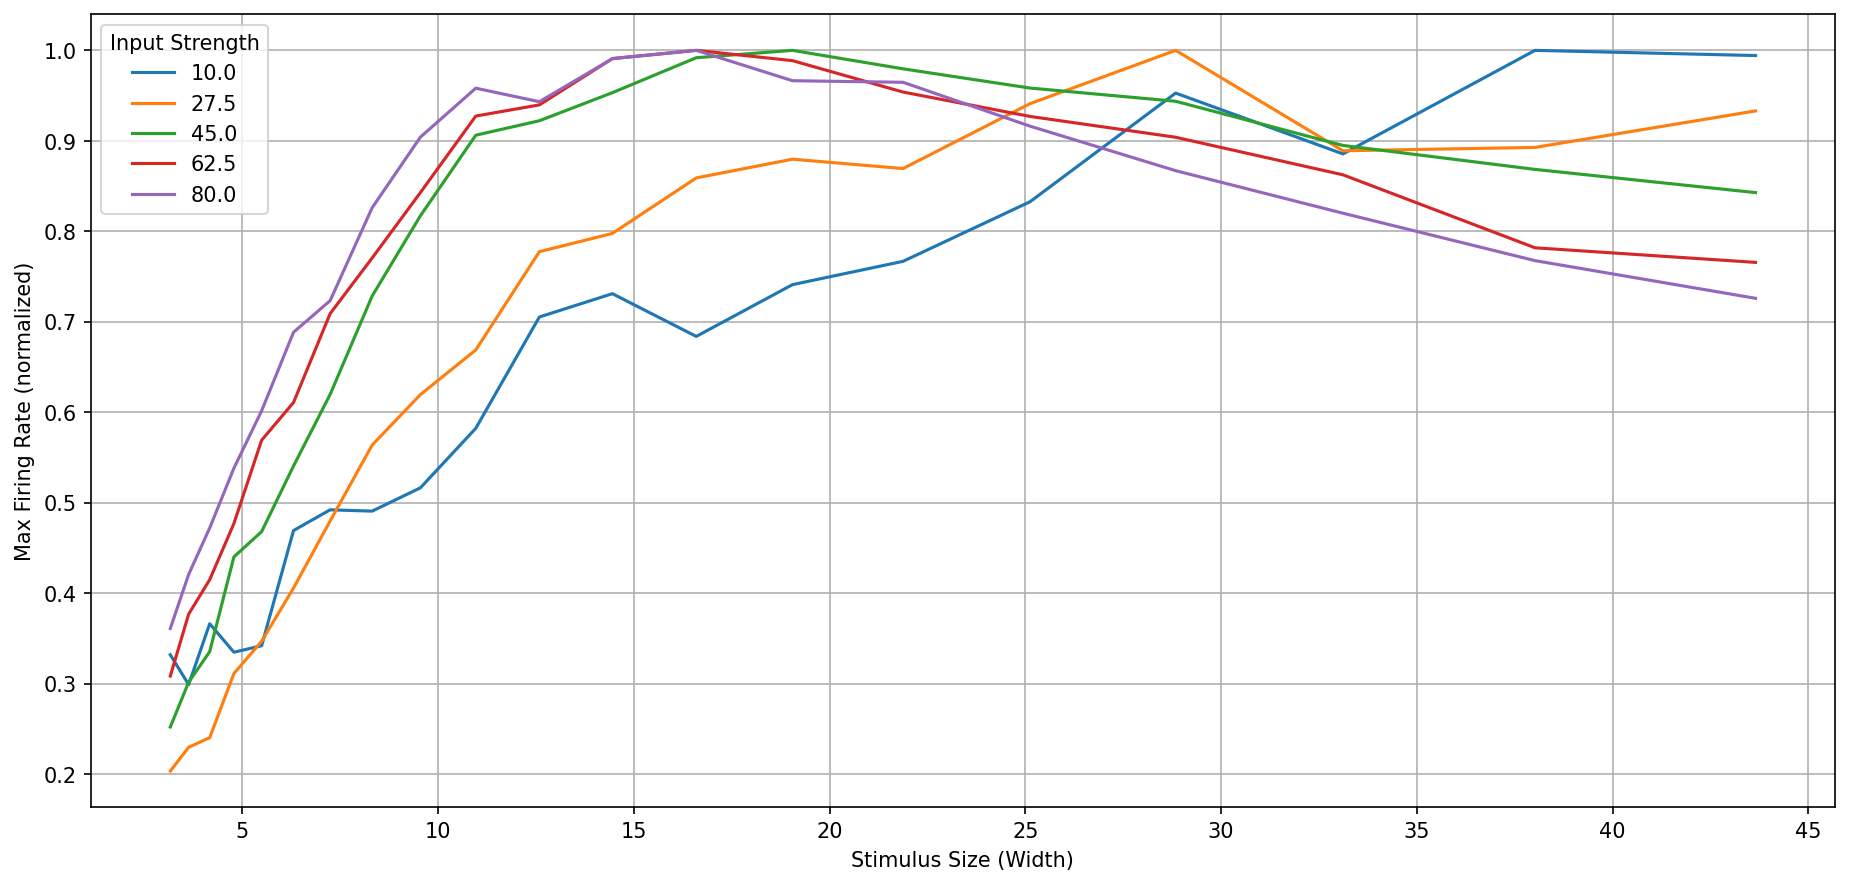

In [218]:
plot_summation_field_curves(curves[:, :], Cs, widths[:])

In [196]:
def double_gaussian_test(params, ratios, C_total=60, dtime=1*second, log_ratio=False):
    if log_ratio:
        ratios = np.exp(ratios)/(1 +  np.exp(ratios))
    step = ratios.shape[0]
    Cs_left = C_total*(1-ratios)
    Cs_right = C_total*ratios
    init_network(params, size_ext=30, C_total=C_total, time_dependency="double_gaussian_ratio", ratios=ratios , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_double = average_firing_rate(step, dtime, params.spike_E)
    init_network(params, time_dependency="contrast", Cs=Cs_right, dtime=dtime, center=135)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_right = average_firing_rate(step, dtime, params.spike_E)
    init_network(params, time_dependency="contrast", Cs=Cs_left, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime*step, variables=[])
    rates_left = average_firing_rate(step, dtime, params.spike_E)
    return rates_double, rates_left, rates_right

def plot_double_gaussian(params, ratios, rates_double, rates_left, rates_right , figsize=(15,30), dpi=200):
    fig, axs = plt.subplots(rates_double.shape[0], 1, figsize=figsize, dpi=dpi)
    for i, (ratio, rate_double, rate_left, rate_right) in enumerate(zip(ratios, rates_double, rates_left, rates_right)):
        axs[i].plot(params.theta[:params.N], rate_double, '.k')
        axs[i].plot(params.theta[:params.N], rate_left, 'C1', label=f'{params.C_total*(1-ratio)}')
        axs[i].plot(params.theta[:params.N], rate_right, 'C2', label=f'{params.C_total*ratio}')
        axs[i].grid()
        axs[i].set_xlabel('theta')
        axs[i].set_ylabel('firing rate (Hz)')
        axs[i].set_title(f'Inputs = {(params.C_total*(1-ratio), params.C_total*ratio)}')
        axs[i].legend(title='Inputs')

# change x to current
# external vs contrast curve 

In [223]:
params = default_params()
ratios = np.array([1/2, 3/8, 1/4, 1/8])
rates_double, rates_left, rates_right = double_gaussian_test(params, ratios, C_total= 150, dtime=150*second)

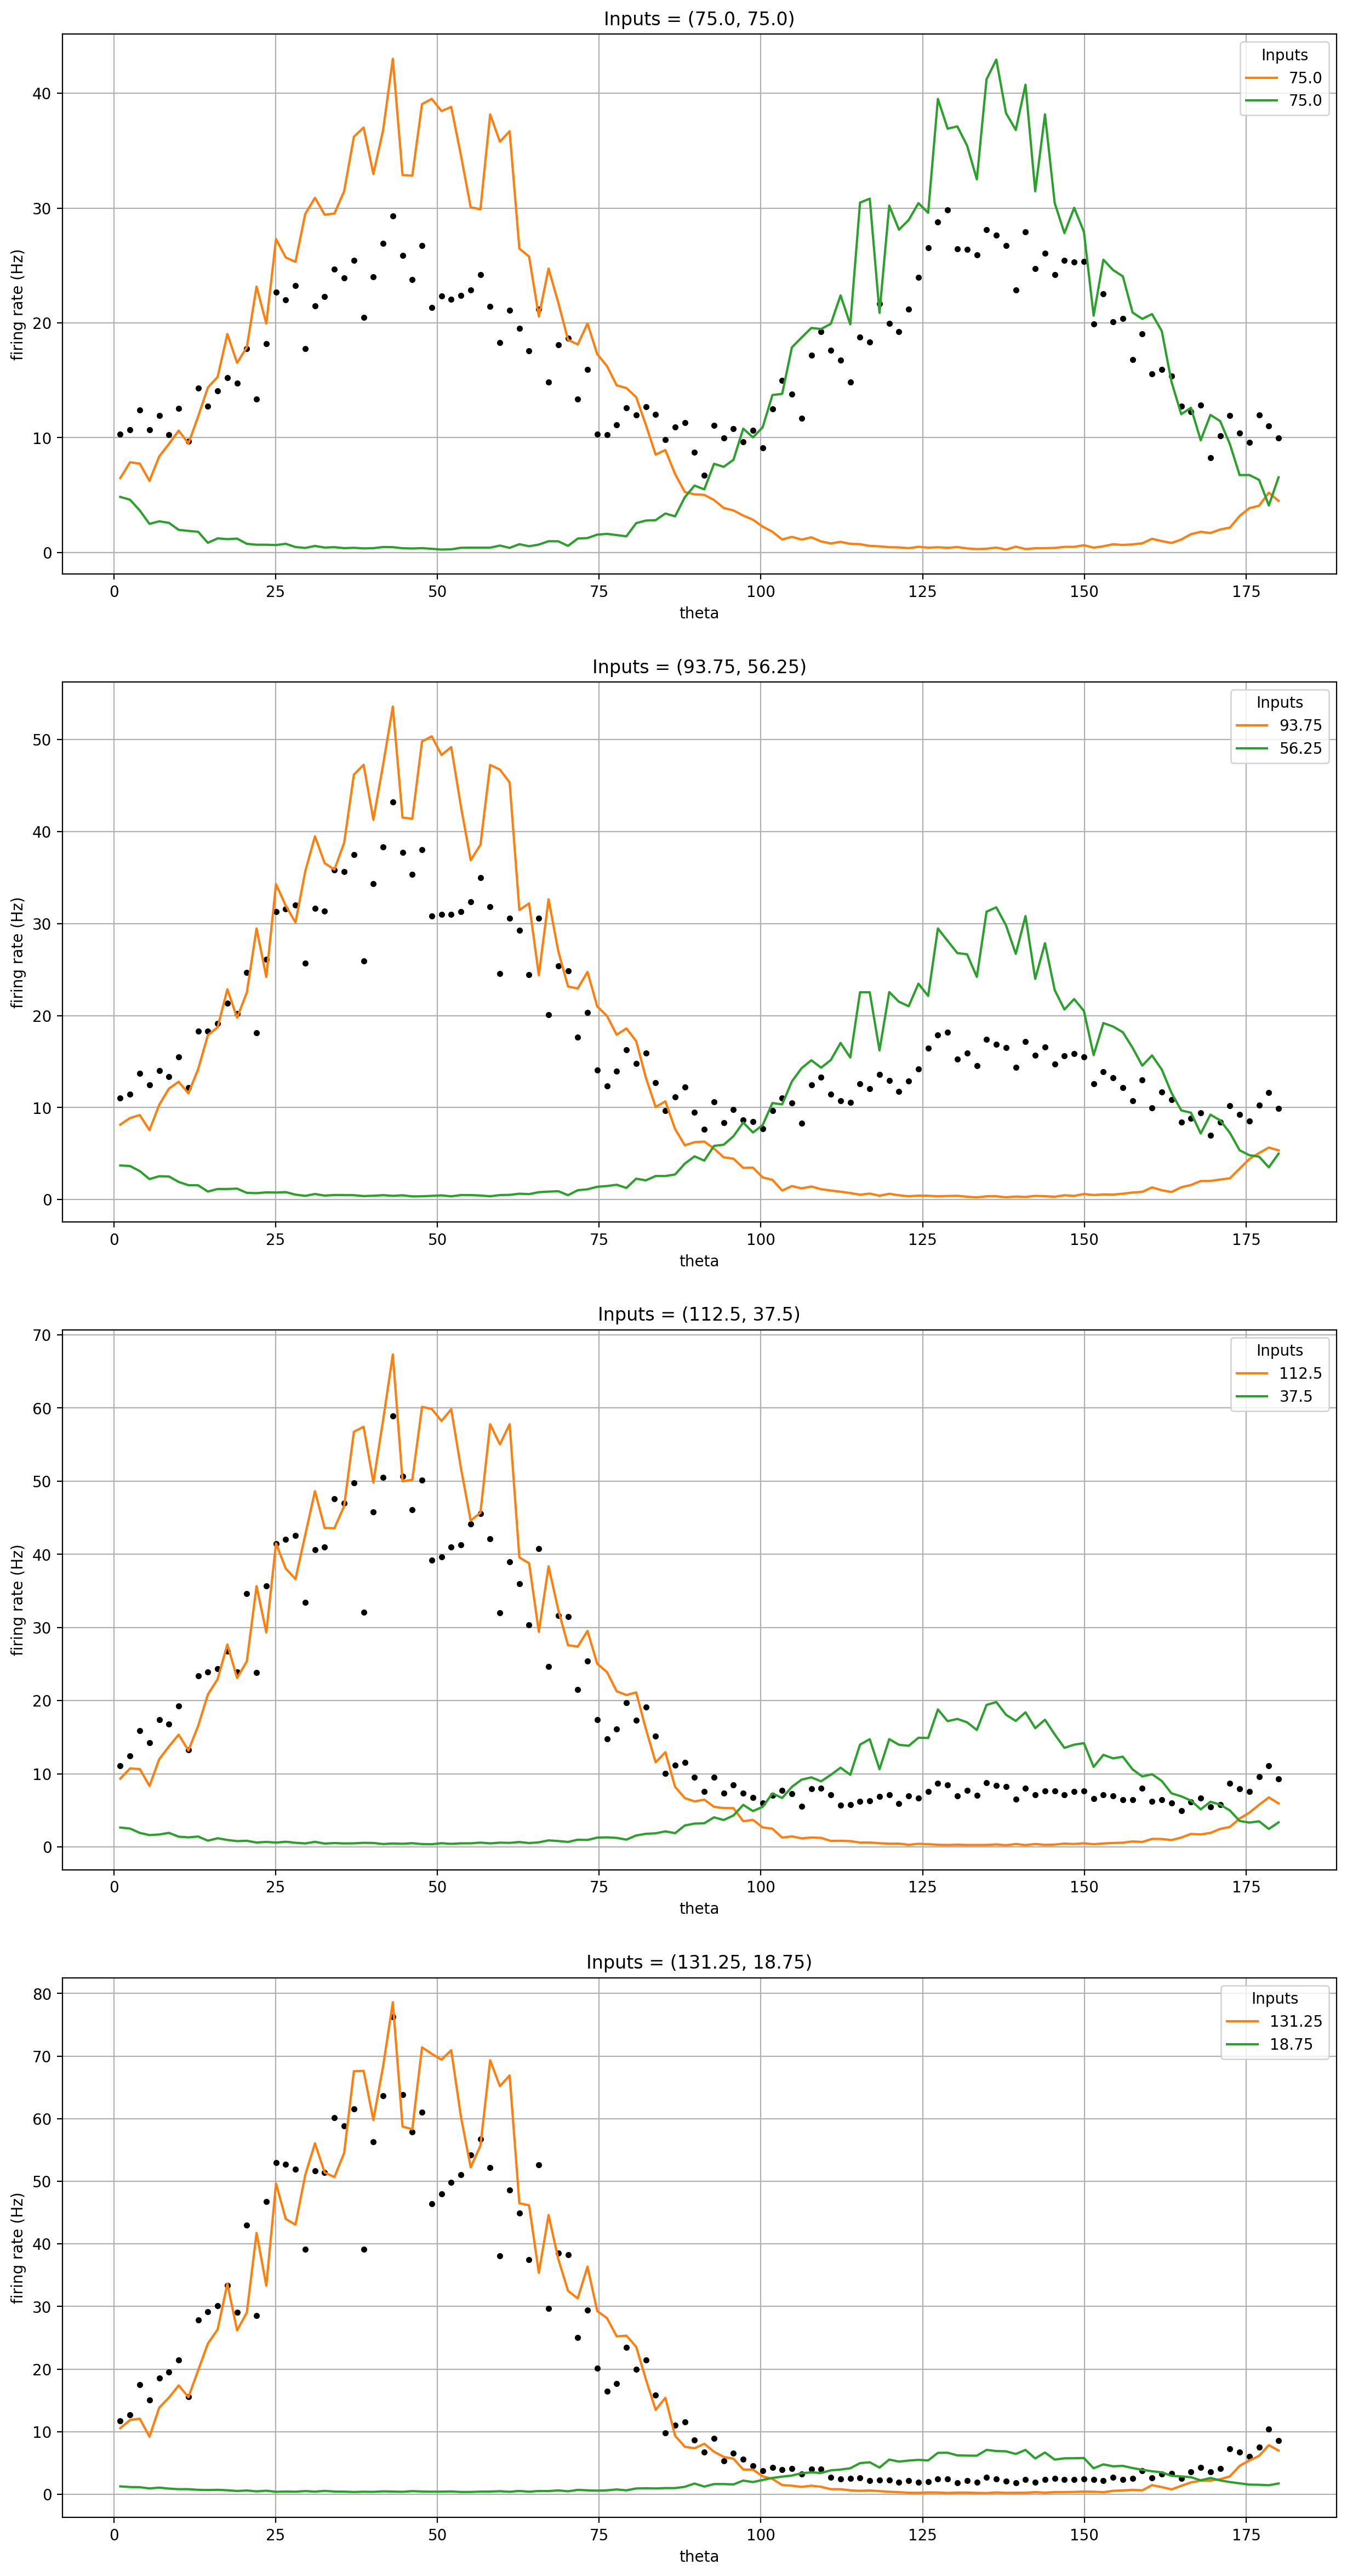

In [224]:
plot_double_gaussian(params, ratios, rates_double, rates_left, rates_right)

In [202]:
def contrast_loop_double(params, Cs, dtime=2*second):
    init_network(params, time_dependency="contrast", Cs=Cs, center=45, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*Cs.shape[0], variables=[])
    step = Cs.shape[0]
    rates_E_single = average_firing_rate(step, dtime, params.spike_E)
    rates_I_single = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast_double_gaussian", Cs=Cs , dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*Cs.shape[0], variables=[])
    step = Cs.shape[0]
    rates_E_double = average_firing_rate(step, dtime, params.spike_E)
    rates_I_double = average_firing_rate(step, dtime, params.spike_I)
    return rates_E_single, rates_I_single, rates_E_double, rates_I_double


def plot_E_I_weight(params, Cs_double, rates_E_single, rates_I_single, rates_E_double, rates_I_double, figsize=(15,8), dpi=200):
    np.seterr(divide='ignore', invalid='ignore')
    weight_E = np.sum(rates_E_double[:, :75], axis=1)/np.sum(rates_E_single[:, :75], axis=1)
    weight_I =  np.sum(rates_I_double[:, :75], axis=1)/np.sum(rates_I_single[:, :75], axis=1)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.plot(Cs_double, weight_E, 'r', label='Excitatory')
    ax.plot(Cs_double, weight_I, 'b', label='Inhibitory')
    ax.grid()
    ax.legend(title='Best Fit Weights')
    ax.set_xlabel('Input Strength')
    ax.set_ylabel('Best Fit Weight')

In [203]:
Cs_double = np.logspace(1, 2, 30) 
rates_E_single, rates_I_single, rates_E_double, rates_I_double = contrast_loop_double(params, Cs_double, dtime=10*second)

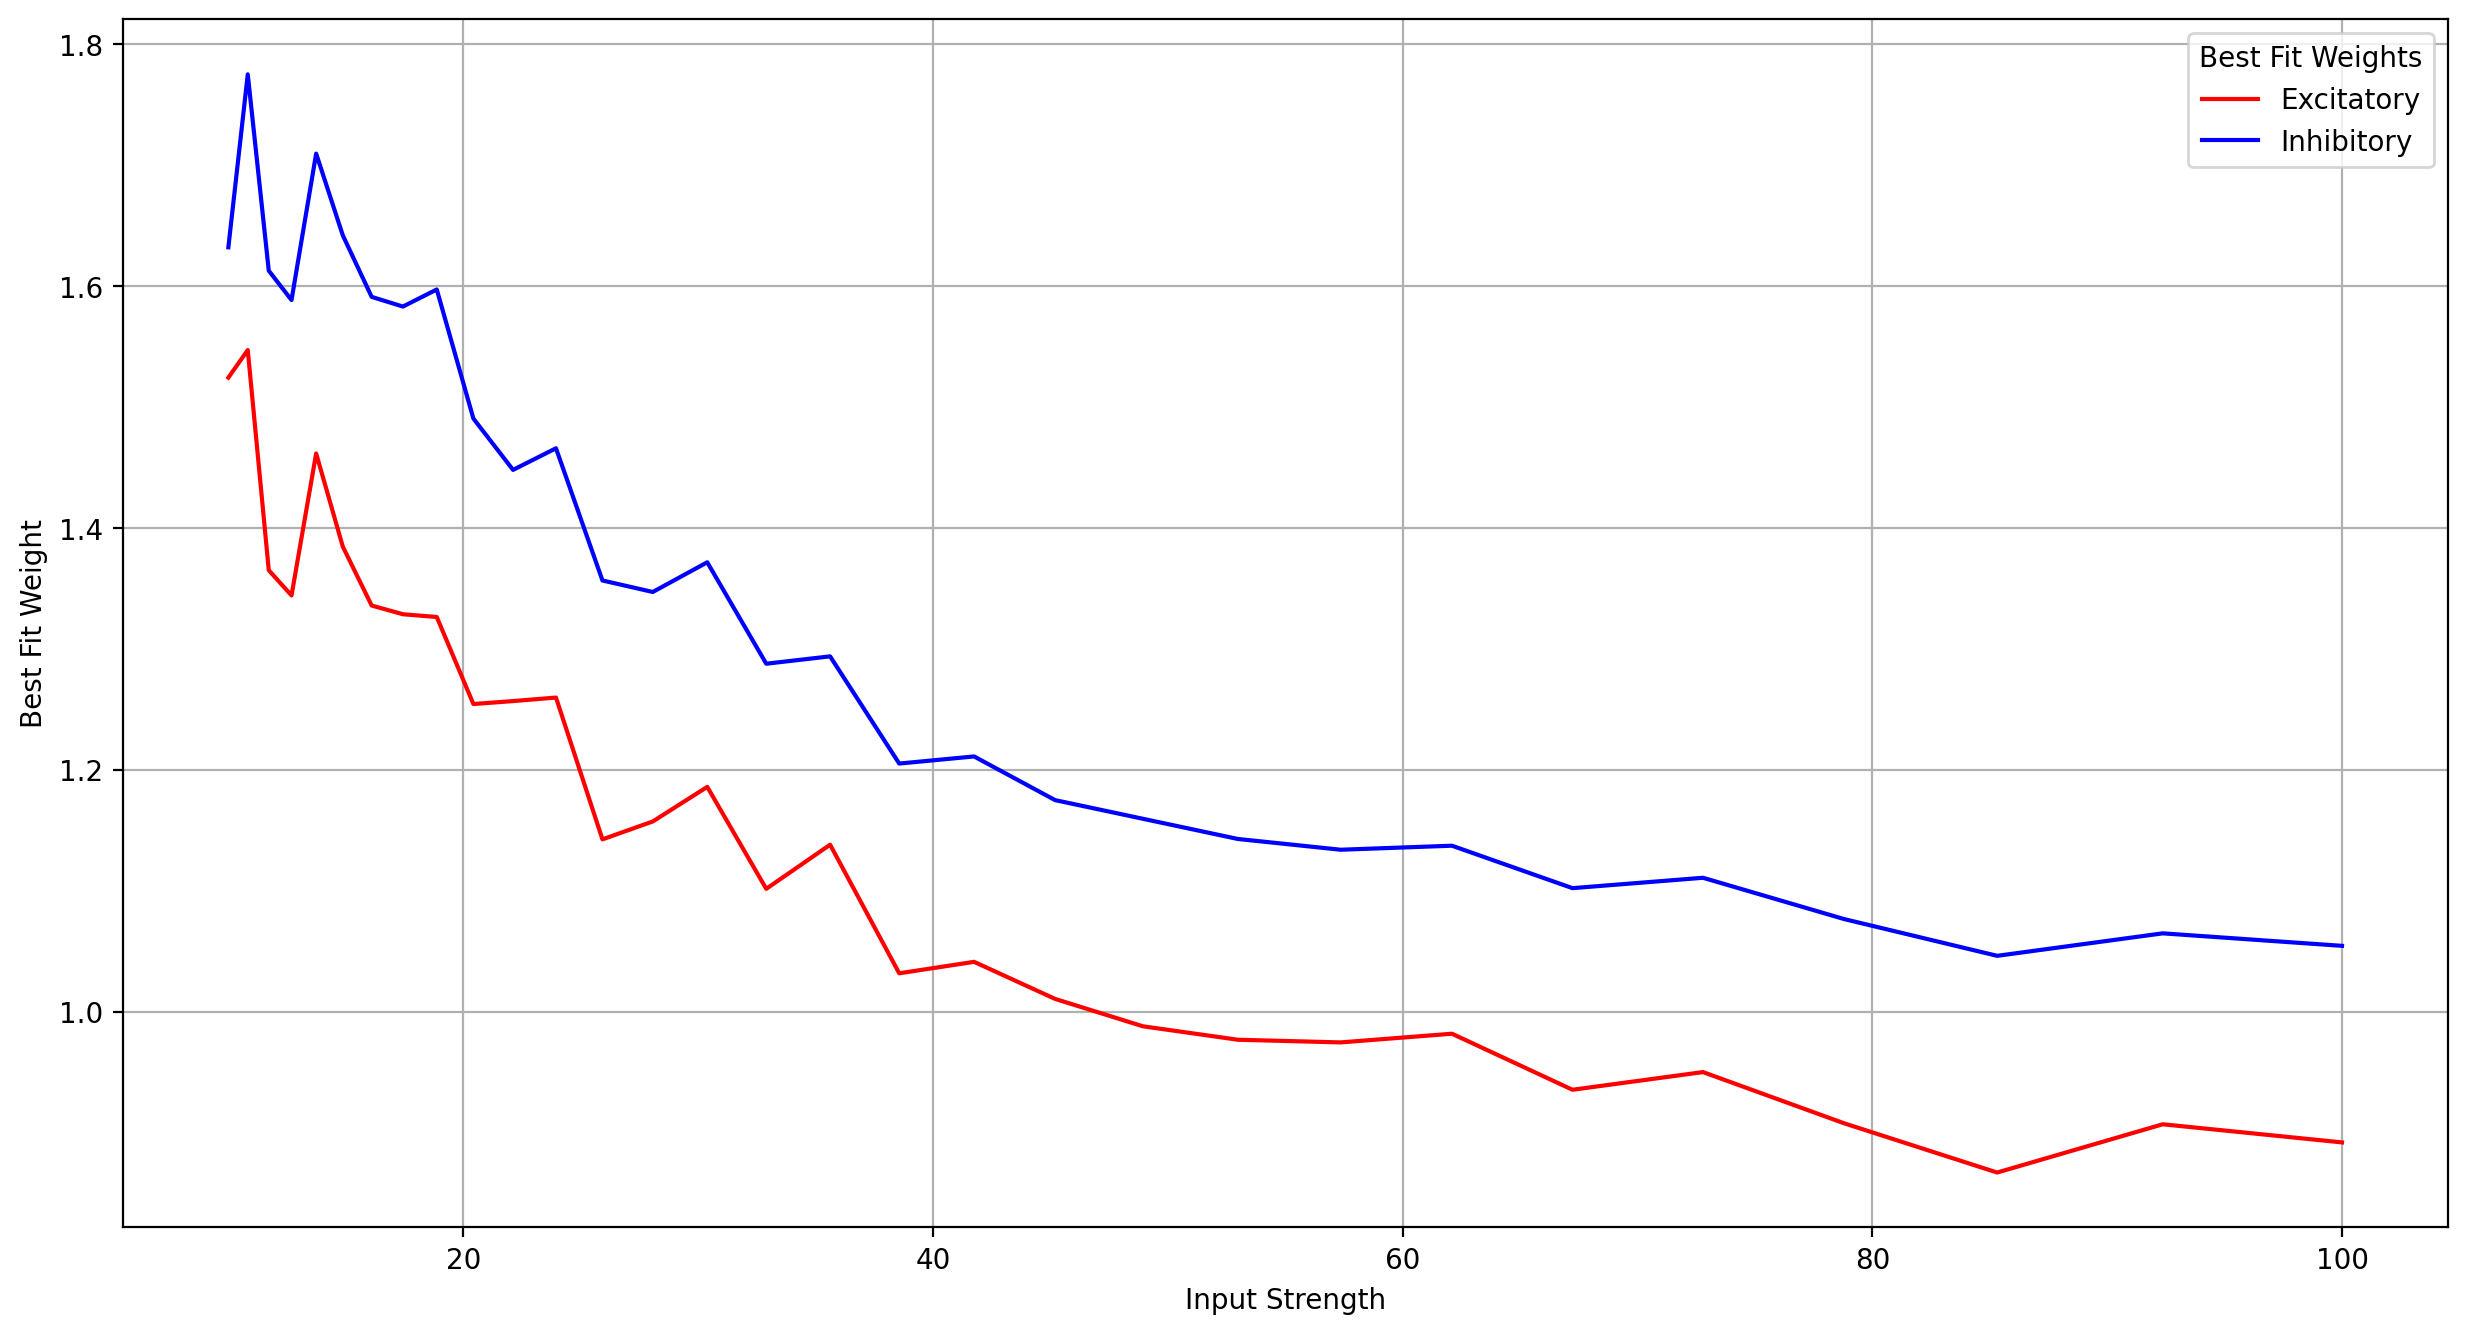

In [204]:
plot_E_I_weight(params, Cs_double, rates_E_single, rates_I_single, rates_E_double, rates_I_double)

In [221]:
def double_mean_sum_test(params, contrasts, dtime=5*second):
    init_network(params, time_dependency="contrast", contrasts=contrasts, center=135, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_right = average_firing_rate(step, dtime, params.spike_E)
    rates_I_right = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast", contrasts=contrasts, center=45, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_left = average_firing_rate(step, dtime, params.spike_E)
    rates_I_left = average_firing_rate(step, dtime, params.spike_I)
    init_network(params, time_dependency="contrast_double_gaussian", contrasts=contrasts, size_ext=30, dtime=dtime)
    build_network(params)
    run_network(params, duration=dtime*contrasts.shape[0], variables=[])
    step = contrasts.shape[0]
    rates_E_double_ = average_firing_rate(step, dtime, params.spike_E)
    rates_I_double_ = average_firing_rate(step, dtime, params.spike_I)
    rates_E_mean = (rates_E_right + rates_E_left)/2
    rates_I_mean = (rates_I_right + rates_I_left)/2
    rates_E_sum =  rates_E_right + rates_E_left
    rates_I_sum =  rates_I_right + rates_I_left
    return rates_E_double_, rates_I_double_, rates_E_mean, rates_I_mean, rates_E_sum, rates_I_sum 


rates_E_double_, rates_I_double_, rates_E_mean, rates_I_mean, rates_E_sum, rates_I_sum = double_mean_sum_test(params, np.array([50]), dtime=10*second)

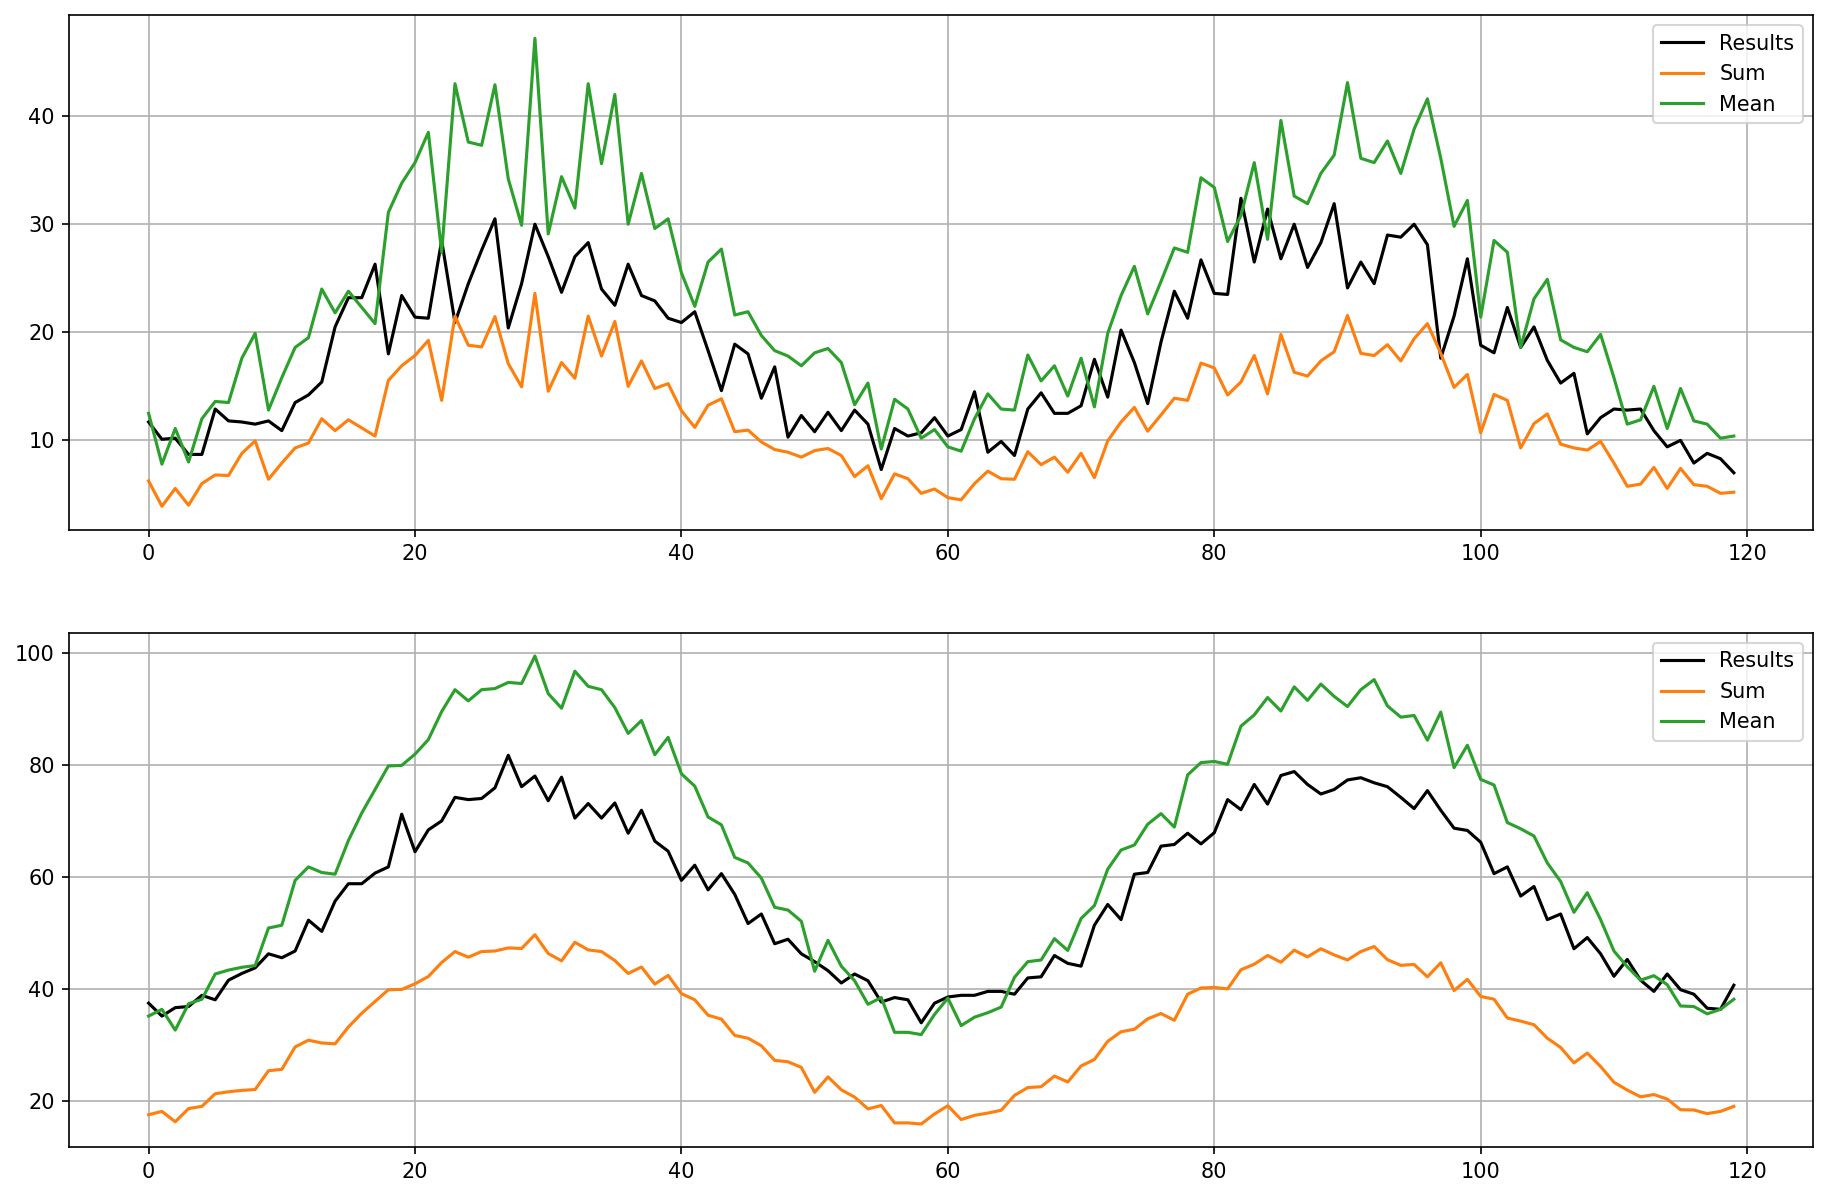

In [222]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(rates_E_double_[0], 'k', label='Results')
axs[0].plot(rates_E_mean[0], 'C1', label='Sum')
axs[0].plot(rates_E_sum[0], 'C2', label='Mean')
axs[1].plot(rates_I_double_[0], 'k', label='Results')
axs[1].plot(rates_I_mean[0], 'C1', label='Sum')
axs[1].plot(rates_I_sum[0], 'C2', label='Mean')
axs[0].grid()
axs[1].grid()
axs[0].legend()
axs[1].legend()
plt.show()


In [ ]:
def s_l(x, l, sigma_RF=.5,):
    return 1/(1+np.exp((-x-l/2)/sigma_RF)) *(1 - 1/(1+np.exp((-x+l/2)/sigma_RF)))
l = np.linspace(1, 12, 8).reshape(-1, 1)
x = np.linspace(-10, 10, 100)